# Sentiment Analysis on Youtube video

## Loading all the libraries

In [312]:
import os
import glob

import youtube_dl

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS

import webvtt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


## User Input - Add any video link from youtube

In [219]:
# Please enter a link
link = input('Please enter a url link:\n')
if not link:
    link = 'https://www.youtube.com/watch?v=BE-cA4UK07c'
print('The link is: ',link)
print('Done, proceed further')

Please enter a url link:

The link is:  https://www.youtube.com/watch?v=BE-cA4UK07c
Done, proceed further


## Function to scrape data from youtube

In [220]:
os.chdir("/Users/shradhitsubudhi/Documents/youtube/downloads")


# To avoid any error while parsing the video, we have created the MyLogger class
class MyLogger(object):
    def debug(self, msg):
        pass

    def warning(self, msg):
        pass

    def error(self, msg):
        print(msg)


# Dictionary to accept some inputs
ydl_opts = {'writesubtitles': True,
            'writeautomaticsub': True,
            'writeinfojson' : True, 
            'format': 'bestaudio/best',
            'logger': MyLogger(),
            'keepvideo': False,
            
            'postprocessors': [{'key': 'FFmpegExtractAudio',
                                'preferredcodec': 'wav',
                                'preferredquality': '192'}],
            'postprocessor_args': ['-ar', '16000']}



# ------------------------------------------------------------------
# Ignore below 2 lines
#with youtube_dl.YoutubeDL(youtube_dl_options) as youtube_dl_client:
#    youtube_dl_client.download([link])
# ----------------------------------------------------------------------

# Extract the audio from the video link along with the subtitles as text
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        meta = ydl.extract_info(link, download=True)    
        
print('Finished extracting audio and subtitles as text!')
print('Please proceed with extracting the below video contents!')
print()
print(""" 'uploader','uploader_url','upload_date','creator','title','description','categories',
      'duration','view_count', 'like_count', 'dislike_count','average_rating','start_time', 'end_time',
      'release_date', 'release_year'""")

Finished extracting audio and subtitles as text!
Please proceed with extracting the below video contents!

 'uploader','uploader_url','upload_date','creator','title','description','categories',
      'duration','view_count', 'like_count', 'dislike_count','average_rating','start_time', 'end_time',
      'release_date', 'release_year'


## Storing all the information in the dataframe

In [244]:
keys = ['uploader','uploader_url','upload_date','creator','title','description','categories',
      'duration','view_count', 'like_count', 'dislike_count','average_rating','start_time', 'end_time',
      'release_date', 'release_year']

filtered_d = dict((k, meta[k]) for k in keys if k in meta)
df = pd.DataFrame.from_dict(filtered_d, orient='index').T
df.index = df['title'] 
df

,uploader,uploader_url,upload_date,creator,title,description,categories,duration,view_count,like_count,dislike_count,average_rating,start_time,end_time,release_date,release_year
title,,,,,,,,,,,,,,,,
The big lesson from South Korea's coronavirus response,Vox,http://www.youtube.com/user/voxdotcom,20200410,None,The big lesson from South Korea's coronavirus ...,Testing and tracing were the key to slowing th...,[News & Politics],483,1348120,41882,1283,4.88111,None,None,None,None


## Extracting the .vtt audio file to get the subtitles converted into text

In [248]:
sub_titles = glob.glob('./*.en.vtt')
sub_titles[0]

"./The big lesson from South Korea's coronavirus response-BE-cA4UK07c.en.vtt"

In [249]:
# Read the file
vtt = webvtt.read(sub_titles[0])
vtt

<WebVTT file=./The big lesson from South Korea's coronavirus response-BE-cA4UK07c.en.vtt>

In [279]:
# Store the starting and ending point of each sentence as part of the start and end list
start_list = list()
end_list = list()

# Storing all the lines as part of the lines list
lines = []

for x in range(len(vtt)):
    start_list.append(vtt[x].start)
    end_list.append(vtt[x].end)

for line in vtt:
    lines.append(line.text.strip().splitlines())
    
lines = [' '.join(item) for item in lines]

## Creating the dataframe to store all the values

In [288]:
final_df = pd.DataFrame({'Start_time':start_list,'End_time':end_list,'Statement':lines})
final_df.head()

,Start_time,End_time,Statement
0,00:00:01.370,00:00:06.910,Countries around the world have shut down to c...
1,00:00:06.910,00:00:12.519,"But in South Korea, people are starting to com..."
2,00:00:12.520,00:00:18.040,"Starting in late February, South Korea was rep..."
3,00:00:18.040,00:00:25.740,"With over 5,000 infected, they were registerin..."
4,00:00:25.740,00:00:27.820,But then something changed.


## Sentiment Analysis - Vader

In [293]:
# Initialize the vader model
sid_obj = SentimentIntensityAnalyzer()

# Compute sentiment scores and labels
sentiment_scores_vader = [sid_obj.polarity_scores(article) for article in final_df.Statement]

sentiment_category_positive = []
sentiment_category_neutral = []
sentiment_category_negative = []
sentiment_category_compound = []

for sentiments in sentiment_scores_vader:
    sentiment_category_positive.append(sentiments['pos'])
    sentiment_category_neutral.append(sentiments['neu'])
    sentiment_category_negative.append(sentiments['neg'])
    sentiment_category_compound.append(sentiments['compound'])
    

# Sentiment statistics per statement
sentiment_df = pd.DataFrame([[article for article in final_df.Statement],
                             sentiment_category_positive,
                             sentiment_category_neutral,
                             sentiment_category_negative,
                             sentiment_category_compound]).T

sentiment_df['Start_time'] = start_list
sentiment_df['End_time'] = end_list

sentiment_df.columns = ['Statement','positive_polarity','neutral_polarity','negative_polarity',
                        'overall_polarity','Start_time','End_time']

sentiment_df.head()

,Statement,positive_polarity,neutral_polarity,negative_polarity,overall_polarity,Start_time,End_time
0,Countries around the world have shut down to c...,0,1,0,0,00:00:01.370,00:00:06.910
1,"But in South Korea, people are starting to com...",0,1,0,0,00:00:06.910,00:00:12.519
2,"Starting in late February, South Korea was rep...",0.15,0.85,0,0.3182,00:00:12.520,00:00:18.040
3,"With over 5,000 infected, they were registerin...",0,0.842,0.158,-0.4939,00:00:18.040,00:00:25.740
4,But then something changed.,0,1,0,0,00:00:25.740,00:00:27.820


## Creating a heatmap to see the change in the polarity of the speech

In [305]:
heatmap_polarity = sentiment_df['overall_polarity'].astype('float').values
heatmap_polarity = heatmap_polarity.reshape(heatmap_polarity.shape[0],1)
heatmap_polarity.shape

(89, 1)

In [306]:
type(heatmap_polarity)

numpy.ndarray

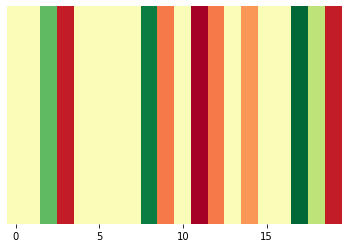

In [309]:
sns.heatmap(data=heatmap_polarity[:20].T, robust=True, cmap='RdYlGn', yticklabels=False, xticklabels=5, cbar=False)

## Word Cloud - To see the most frequent words

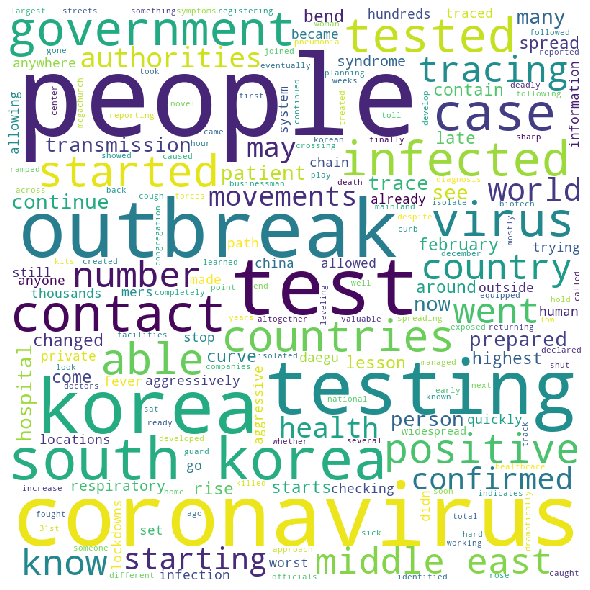

In [313]:
comment_words = ' '
stopwords = set(STOPWORDS)

# iterate through the corpus
for val in sentiment_df.Statement:
    
    # typecaste each val to string
    val = str(val)
    
    # split the value
    tokens = val.split()
    
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    for words in tokens:
        comment_words = comment_words + words + ' '
        
wordcloud = WordCloud(width = 800, height = 800,
                     background_color = 'white',
                     stopwords = stopwords,
                     min_font_size = 10).generate(comment_words)

# Plot the WordCloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()